In [1]:
import math
import random
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

img_path :  data/images/wheaten_terrier_122.jpg
mask_path :  data/annotations/trimaps/wheaten_terrier_122.png
[1 2 3]


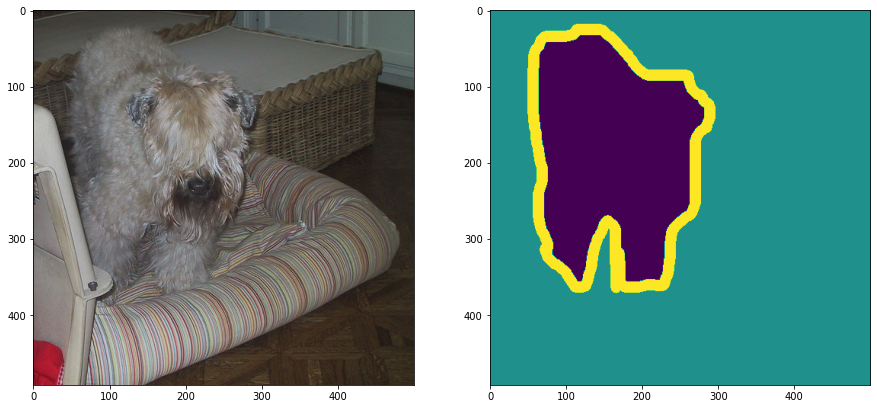

In [2]:
csv_path = 'data/kfolds.csv'
df = pd.read_csv(csv_path)
idx = random.choice(range(len(df)))

file_name = df.loc[idx].file_name
img_path = f'data/images/{file_name}.jpg'
mask_path = f'data/annotations/trimaps/{file_name}.png'

print('img_path : ', img_path)
print('mask_path : ', mask_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))
assert img.shape[:2] == mask.shape[:2]

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [3]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                # 이동, 크기, 회전을 설정
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 최대 8개의 구멍을 dropout 하게됨
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
    
    def __call__(self, **kwargs): # {image=image, mask=mask}
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### https://github.com/tensorflow/models/issues/3134
        #### 파일 이슈 -> 삭제
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()

        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png', cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            if self.mode == 'train':
#                 image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
            
            image = image.astype('float32')            
            image = image / 255.
            mask = mask.astype('float32')
        
            # label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(mask)
        return batch_x, batch_y

    
csv_path = 'data/kfolds.csv'

train_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 128,
    mode = 'train',
    shuffle = True
)

valid_generator = DataGenerator(
    batch_size = 128,
    csv_path = csv_path,
    fold = 1,
    image_size = 128,
    mode = 'val',
    shuffle = True
)

In [5]:
# https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape = (128, 128, 3),
    use_batch_norm = True,
    num_classes = 3,
    filters = 64, 
    dropout = 0.2,
    use_attention = True,
    output_activation='softmax'
)

model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 64  1728        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

                                                                                                  
 conv2d_29 (Conv2D)             (None, 16, 16, 512)  262656      ['batch_normalization_25[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 16, 16, 512)  262656      ['conv2d_transpose_4[0][0]']     
                                                                                                  
 add (Add)                      (None, 16, 16, 512)  0           ['conv2d_29[0][0]',              
                                                                  'conv2d_30[0][0]']              
                                                                                                  
 activation (Activation)        (None, 16, 16, 512)  0           ['add[0][0]']                    
                                                                                                  
 conv2d_31

                                                                                                  
 conv2d_42 (Conv2D)             (None, 64, 64, 128)  294912      ['concatenate_6[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 64, 64, 128)  512        ['conv2d_42[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_43 (Conv2D)             (None, 64, 64, 128)  147456      ['batch_normalization_32[0][0]'] 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 64, 64, 128)  512        ['conv2d_43[0][0]']              
 ormalization)                                                                                    
          

In [6]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1
)


Epoch 1/20


KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
history = history.history
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")
plt.show()

NameError: name 'history' is not defined

In [8]:
for images, mask in valid_generator:
    break
    
preds = model.predict(images)

NameError: name 'masks' is not defined

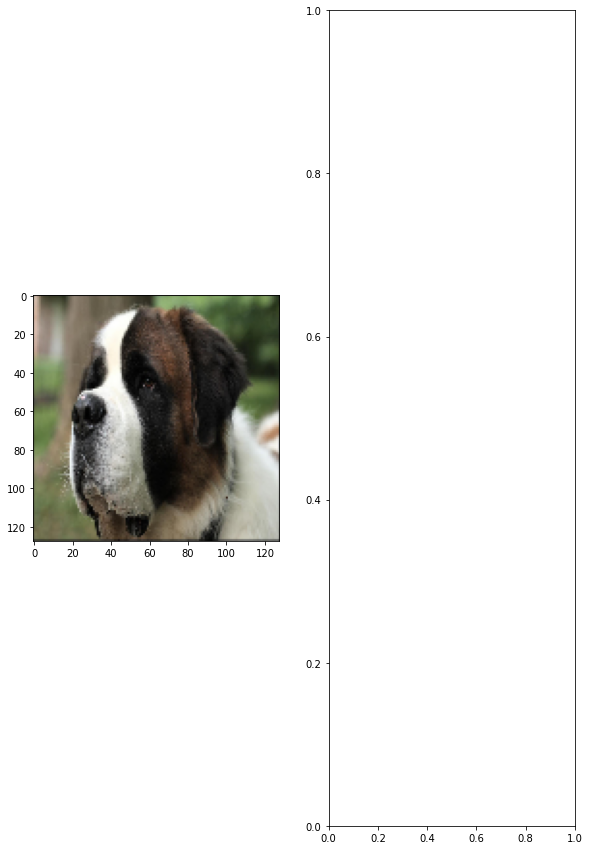

In [10]:
idx = random.choice(range(len(preds)))
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(images[idx, ...])
plt.subplot(1, 3, 2)
plt.imshow(masks[idx])
plt.subplot(1, 3, 3)
pred = np.argmax(preds[idx], axis=-1)
plt.imshow(pred)

In [11]:
np.unique(pred)

NameError: name 'pred' is not defined